# Umbrella Sampling of the two-well potential

Here, we define an umbrella sampling object, `UmbrellaSampler()` that can perform biased sampling of the two-well potential.

In [7]:
import os, sys
import numpy as np

class UmbrellaSampler(object):
    """A Sampler class that can perform biased sampling of the two-well potential."""
    
    def __init__(self,
                 x0_values = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5],
                 kspring_values  = [2.0]*9):
        """Initialize the UmbrellaSampler class.
        
        PARAMETERS
        x0_values - a list of x0 positions of the umbrella anchors
        kspring_values  - a list of force constant values, in kcal/mol/[x]^2
        """
        
        self.x0_values = x0_values  # Umbrella anchor positions
        self.kspring_values = kspring_values    # force constant values, in kcal/mol/[x]^2
        
        assert len(self.x0_values) == len(self.kspring_values)
        
        self.K = len(self.x0_values)  # the number of thermodynamic ensembles
        
    
    def U(self, x, x0=0.0, kspring=0.0):
        """Return the value of the **biased** 1D potential energy surface in kcal/mol:

        U(x) = -2 \ln [ e^{-2(x-2)^2-2} + e^{-2(x-5)^2} ] + (k/2.)(x - x0)**2
        """
        result = -2.0*np.log( np.exp(-2.0*(x-2)**2 - 2) + np.exp(-2.0*(x-5)**2) )
        result += kspring/2.*(x - x0)**2
        return result

    
    def dU_kl(self, x, k, l):
        """Return the difference of the potential energy $\Delta U_kl(x)$ for a snapshot
        from ensemble index k, re-evaluated in ensemble index l:
        
        \Delta U_kl(x) = (bias from ens. l) - (bias from ens k.)
        
        """
        result = self.kspring_values[l]/2.*(x - self.x0_values[l])**2
        result -= self.kspring_values[k]/2.*(x - self.x0_values[k])**2
         
        return result


    def sample(self, xinit, nsteps, thermo_index, djump=0.05, xmin=1.5, xmax=5.5,
               kT=0.596, nstride=100, nprint=10000, verbose=False):
        """Perform Monte Carlo sampling of the potential energy surface U
        by 

        INPUT
        xinit        - the starting position
        nsteps       - number of steps of Monte Carlo to perform
        thermo_index - the index of the thermodynamic ensemble to sample
        
        PARAMS
        djump    attempt random moves drawn from [-djump, +djump]
        xmin     reject moves x < xmin
        xmax     reject moves x > xmax
        kT       thermal energy in units of kcal/mol (Default: 0.596)
        nstride  frequency of step to subsample the trajectory

        Note:  the djump=0.005 parameter is from the 2017 Stelzl et al. paper    
        """
        
        assert (thermo_index < self.K)
        
        x = xinit
        energy = self.U(x, self.x0_values[thermo_index], self.kspring_values[thermo_index])

        step = 0
        accepted_steps = 0
        traj = np.zeros( int(nsteps/nstride) )
        itraj = 0

        # pre-calculate random numbers
        r = np.random.random( nsteps )
        s = np.random.random( nsteps )

        while step < nsteps:

            xnew = x + djump*(2.0*s[step]-1.0)
            new_energy = self.U(xnew, self.x0_values[thermo_index], self.kspring_values[thermo_index])

            # calculate Metropolis acceptance 
            accept = (r[step] < min(1, np.exp( -1.0*(new_energy-energy)/kT ) ))

            # reject moves that bring x outside the range
            accept = accept*(xnew>xmin)*(xnew<xmax)

            if accept:
                accepted_steps += 1
                x = xnew
                energy = self.U(x, self.x0_values[thermo_index], self.kspring_values[thermo_index])

            if step%nstride == 0:
                traj[itraj] = x
                itraj += 1

            if verbose:
                if step%nprint == 0:
                    print('step', step, 'of', nsteps, ': x =', x, 'energy =', energy)

            step += 1
            acc_ratio = float(accepted_steps)/float(step)

        return traj

Here's a plot of what all the biased potentials in each ensemble looks like:

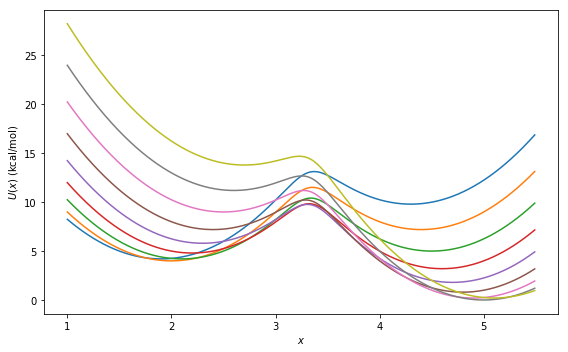

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

s = UmbrellaSampler()
K = 9

plt.figure(figsize=(8,5))
x = np.arange(1.0, 5.5, 0.01)
for thermo_index in range(K):
    plt.plot(x, s.U(x, s.x0_values[thermo_index], s.kspring_values[thermo_index]))
plt.xlabel('$x$')
plt.ylabel('$U(x)$ (kcal/mol)')
plt.tight_layout()

In [9]:
s = UmbrellaSampler(
        x0_values = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5],
        kspring_values  = [2.0]*9)
K = 9  # number of thermodynamic ensembles

ntrials = 5
xinit_per_trial = [1.5, 2.5, 3.5, 4.5, 5.5]
nsteps = 10000
nstride = 100
nsamples = int(nsteps/nstride)
print('nsamples', nsamples)

trajdata = np.zeros( (K,ntrials,nsamples))
print('trajdata.shape', trajdata.shape)
print('The `trajdata` array uses', trajdata.nbytes, 'bytes')

for thermo_index in range(K):
    print('traj', thermo_index, 'of', K, '| trial: ', end ='')
    for trial in range(ntrials):
        trajdata[thermo_index,trial,:] = s.sample(xinit_per_trial[trial],
                                                  nsteps, thermo_index, nstride=nstride,
                                                  xmin=-100.0, xmax=100.0)   # make
        print(trial, end = ' ')
    print('')

nsamples 100
trajdata.shape (9, 5, 100)
The `trajdata` array uses 36000 bytes
traj 0 of 9 | trial: 0 1 2 3 4 
traj 1 of 9 | trial: 0 1 2 3 4 
traj 2 of 9 | trial: 0 1 2 3 4 
traj 3 of 9 | trial: 0 1 2 3 4 
traj 4 of 9 | trial: 0 1 2 3 4 
traj 5 of 9 | trial: 0 1 2 3 4 
traj 6 of 9 | trial: 0 1 2 3 4 
traj 7 of 9 | trial: 0 1 2 3 4 
traj 8 of 9 | trial: 0 1 2 3 4 


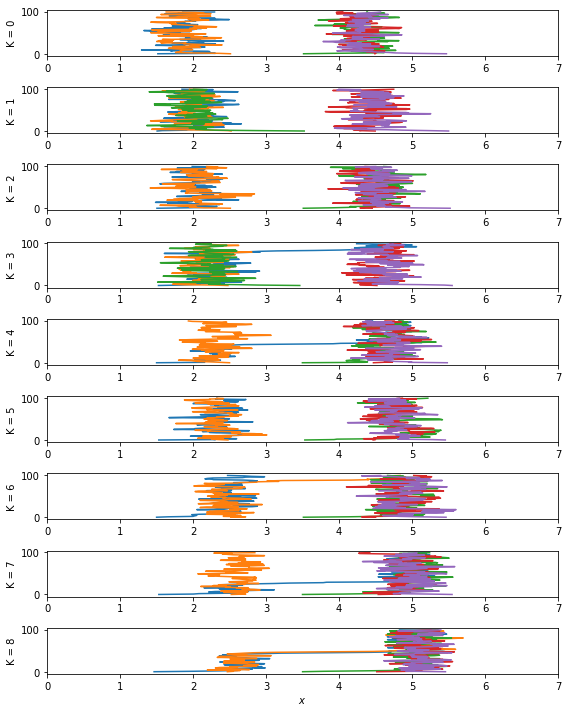

In [10]:
# Plot the results    
plt.figure(figsize=(8,10))
for thermo_index in range(K):
    plt.subplot(K,1,thermo_index+1)
    for trial in range(ntrials):
        plt.plot(trajdata[thermo_index,trial,:], range(nsamples))
    if thermo_index == (K-1):
        plt.xlabel('$x$')
    plt.ylabel('K = %d'%thermo_index)
    plt.xlim(0,7.0)
plt.tight_layout()

## MBAR estimation of the free energy between wells

In [11]:

from pymbar import MBAR # multistate Bennett acceptance ratio
from pymbar import timeseries # timeseries analysis

VERBOSE = True
# First let's compute the lengths of all the trajectories

# N_k is the number of trajectory snapshots sampled in each enesmble 
N_k = nsamples*np.ones([K], dtype = int)   # make an empty array for now
print('N_k', N_k)
N_max = np.max(N_k)
print('N_max', N_max)


N_k [100 100 100 100 100 100 100 100 100]
N_max 100


In [14]:
# Next, we will create and fill the array u_kln
L = K
u_kln = np.zeros([K,L,N_max], np.float64) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella 

# Let's also keep track of all the reduced energies as calculated for the unbiased ensemble (k=0)
N_tot = N_k.sum()
u_n = np.zeros(N_tot)
u_n_fill_indices = [0] 
for k in range(K):
    u_n_fill_indices.append( u_n_fill_indices[-1] + N_k[k])
print('len(u_n_fill_indices)', len(u_n_fill_indices))
print('u_n_fill_indices', u_n_fill_indices)
print('len(u_n)', len(u_n))

"""
for k in range(K):    
    for l in range(L):
        u_kln[k,l,0:N_k[k]] = reduced_potential_for_l - reduced_potential_for_k
        
        ## store energies u_n for the unbiased ensemble
        if l == 0:
            print('u_n_fill_indices[k],u_n_fill_indices[k+1]', u_n_fill_indices[k],u_n_fill_indices[k+1])
            u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = reduced_potential_for_l - reduced_potential_for_k

print('u_kln', u_kln)
print('u_n', u_n)
"""

len(u_n_fill_indices) 10
u_n_fill_indices [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
len(u_n) 900


"\nfor k in range(K):    \n    for l in range(L):\n        u_kln[k,l,0:N_k[k]] = reduced_potential_for_l - reduced_potential_for_k\n        \n        ## store energies u_n for the unbiased ensemble\n        if l == 0:\n            print('u_n_fill_indices[k],u_n_fill_indices[k+1]', u_n_fill_indices[k],u_n_fill_indices[k+1])\n            u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = reduced_potential_for_l - reduced_potential_for_k\n\nprint('u_kln', u_kln)\nprint('u_n', u_n)\n"